## 10-417 Final Project

The original codebase was from https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb


## Environment Set-up

In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U pretrainedmodels efficientnet-pytorch albumentations
!pip install -U torchnet

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-mhz97p11
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-mhz97p11
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import numpy as np
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
import sys
import torch
from tqdm import tqdm as tqdm
import torchnet
from torchnet.meter import AverageValueMeter
from segmentation_models_pytorch import utils
import torch.nn as nn

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks

All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [ ]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
lambda = 1 - (x2-x1)*(y2-y1)/(W*H)
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.unlabelled_class = self.CLASSES.index('unlabelled')

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    # Refer to official cutmix impl. https://github.com/clovaai/CutMix-PyTorch/blob/2d8eb68faff7fe4962776ad51d175c3b01a25734/train.py#L279
    def rand_bbox(self, size, lam):
        H, W = size[0], size[1]
        cut_rat = np.sqrt(1.0 - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W - 1)
        bby1 = np.clip(cy - cut_h // 2, 0, H - 1)
        bbx2 = np.clip(cx + cut_w // 2, 0, W - 1)
        bby2 = np.clip(cy + cut_h // 2, 0, H - 1)
        return bbx1, bby1, bbx2, bby2

    # mask for the cut loss
    def lcut_mask(self, H, W, start_x, start_y, end_x, end_y, include_inside):
        a = self.lcut_alpha
        b = self.lcut_beta
        img = torch.zeros((H, W))
        # whether to include loss inside of the cut out rectangle
        max_offset = b + 1 if include_inside else 0
        for offset in range(-b, max_offset):
            loss = a ** abs(offset)
            x1 = np.clip(start_x + offset, 0, W - 1)
            x2 = np.clip(end_x - offset, 0, W - 1)
            y1 = np.clip(start_y + offset, 0, H - 1)
            y2 = np.clip(end_y - offset, 0, H - 1)
            img[y1: y2 + 1, x1] = loss
            img[y1: y2 + 1, x2] = loss
            img[y1, x1:x2 + 1] = loss
            img[y2, x1:x2 + 1] = loss
        return img

    def make_one_hot(self, labels, C):  # labels: [N]
        """turn a batch of labels to the one-hot form"""
        labels = labels.unsqueeze(1)  # [N, 1]
        one_hot = torch.zeros(labels.size(0), C).cuda()
        target = one_hot.scatter_(1, labels, 1)
        return target

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

### Cut Out Dataloader

Refer to official cutmix implementation: https://github.com/clovaai/CutMix-PyTorch/blob/2d8eb68faff7fe4962776ad51d175c3b01a25734/train.py#L234

Cutout implementation is similar to cutmix implementation.


In [ ]:
class CutOutDataset(Dataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        lcut_alpha,
        lcut_beta,
        classes=None,
        augmentation=None,
        preprocessing=None,
  ):
        super().__init__(images_dir, masks_dir, classes, augmentation, preprocessing)
        self.lcut_alpha = lcut_alpha
        self.lcut_beta = lcut_beta

    def cutout(self, img, mask):
        shape = img.shape
        h, w, _ = shape
        self.lam = np.random.beta(1, 1)

        bbx1, bby1, bbx2, bby2 = self.rand_bbox(
            shape, self.lam
        )  # self.lam is the area ratio of the remaining part over the original image

        # get new image
        cutout_mask = np.ones((h, w, 1))
        cutout_mask[bby1:bby2 + 1, bbx1:bbx2 + 1] = 0
        input_cut = img * cutout_mask

        # adjust lambda to exactly match pixel ratio
        self.lam = 1 - (bbx2 - bbx1 + 1) * (bby2 - bby1 + 1) / (h * w)

        mask_mix = np.where(cutout_mask, mask, self.unlabelled_class)

        lcut_mask = self.lcut_mask(h, w, bbx1, bby1, bbx2, bby2, include_inside=False)

        return input_cut, mask_mix, lcut_mask

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply cutout
        image, mask, lcut_mask = self.cutout(image, mask)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image.astype(np.uint8), mask, lcut_mask

### Cut Mix Dataloader

Refer to official cutmix implementation: https://github.com/clovaai/CutMix-PyTorch/blob/2d8eb68faff7fe4962776ad51d175c3b01a25734/train.py#L234


In [ ]:
class CutMixDataset(Dataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        lcut_alpha=300,
        lcut_beta=0,
        classes=None,
        augmentation=None,
        preprocessing=None,
  ):
        super().__init__(images_dir, masks_dir, classes, augmentation, preprocessing)
        self.lcut_alpha = lcut_alpha
        self.lcut_beta = lcut_beta
        self.ids_shuffled = self.ids.copy()
        random.shuffle(self.ids_shuffled)

        self.images_fps_shuffled = [os.path.join(images_dir, image_id) for image_id in self.ids_shuffled]
        self.masks_fps_shuffled = [os.path.join(masks_dir, image_id) for image_id in self.ids_shuffled]

    def cutmix(self, img1, mask1, img2, mask2):
        shape = img1.shape
        h, w, _ = shape
        self.lam = np.random.beta(1, 1)

        bbx1, bby1, bbx2, bby2 = self.rand_bbox(
            shape, self.lam
        )  # self.lam is the area ratio of the remaining part over the original image

        # get new image
        cutmix_mask = np.ones((h, w, 1))
        cutmix_mask[bby1:bby2 + 1, bbx1:bbx2 + 1] = 0
        input_cut = img1 * cutmix_mask + img2 * (1 - cutmix_mask)

        # adjust lambda to exactly match pixel ratio
        self.lam = 1 - (bbx2 - bbx1 + 1) * (bby2 - bby1 + 1) / (h * w)

        # linearly interpolate the mask
        mask_mix = cutmix_mask * mask1 + (1 - cutmix_mask) * mask2

        lcut_mask = self.lcut_mask(h, w, bbx1, bby1, bbx2, bby2, include_inside=True)

        return input_cut, mask_mix, lcut_mask

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        image2 = cv2.imread(self.images_fps_shuffled[i])
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        mask2 = cv2.imread(self.masks_fps_shuffled[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        masks2 = [(mask2 == v) for v in self.class_values]
        mask2 = np.stack(masks2, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

            sample2 = self.augmentation(image=image2, mask=mask2)
            image2, mask2 = sample2['image'], sample2['mask']

        # apply cutout
        image, mask, lcut_mask = self.cutmix(image, mask, image2, mask2)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image.astype(np.uint8), mask, lcut_mask


### Visualize Augmented Dataset Using Cut Out and Cut Mix


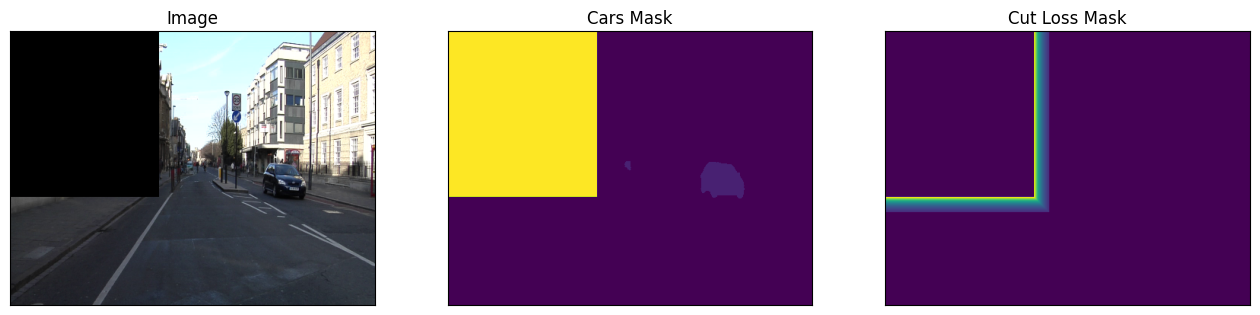

In [ ]:
dataset = CutOutDataset(x_train_dir, y_train_dir, lcut_alpha=0.9, lcut_beta = 20, classes=['car'])

image, mask, lcut_mask = dataset[40] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
    cut_loss_mask=lcut_mask
)

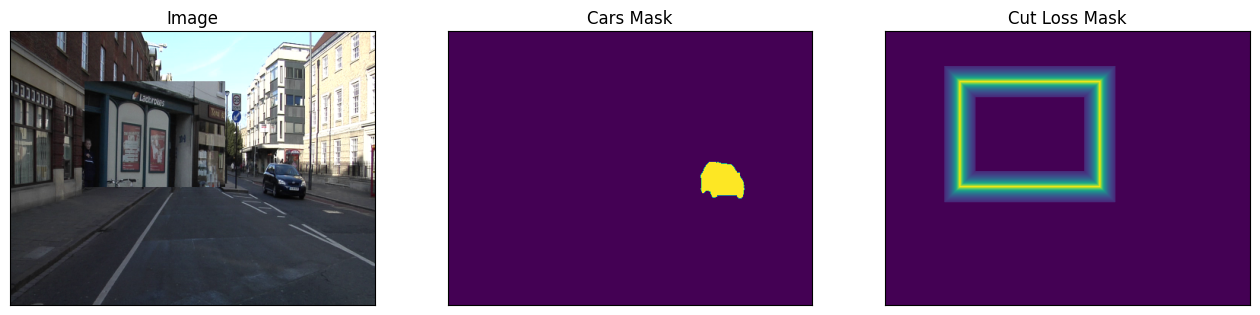

In [ ]:
dataset = CutMixDataset(x_train_dir, y_train_dir, lcut_alpha=0.9, lcut_beta = 20, classes=['car'])

image, mask, lcut_mask = dataset[40] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
    cut_loss_mask=lcut_mask
)

### Basic Augmentations

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

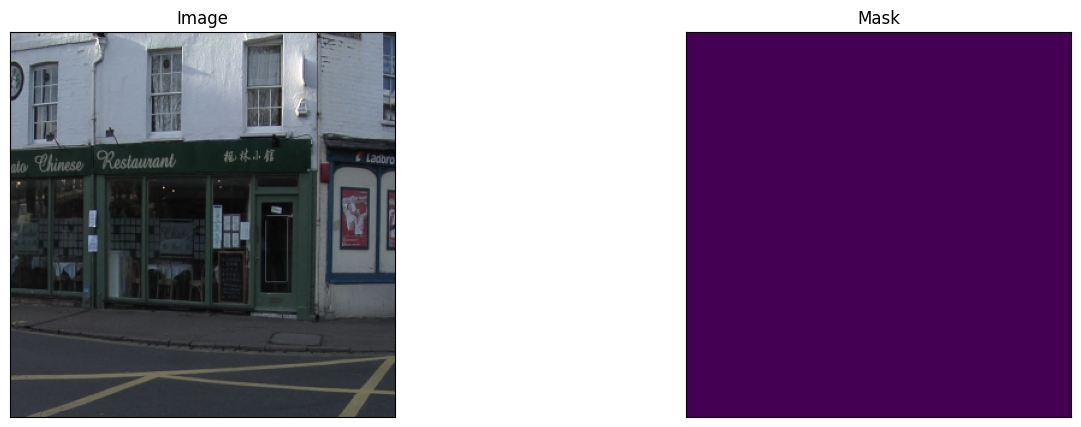

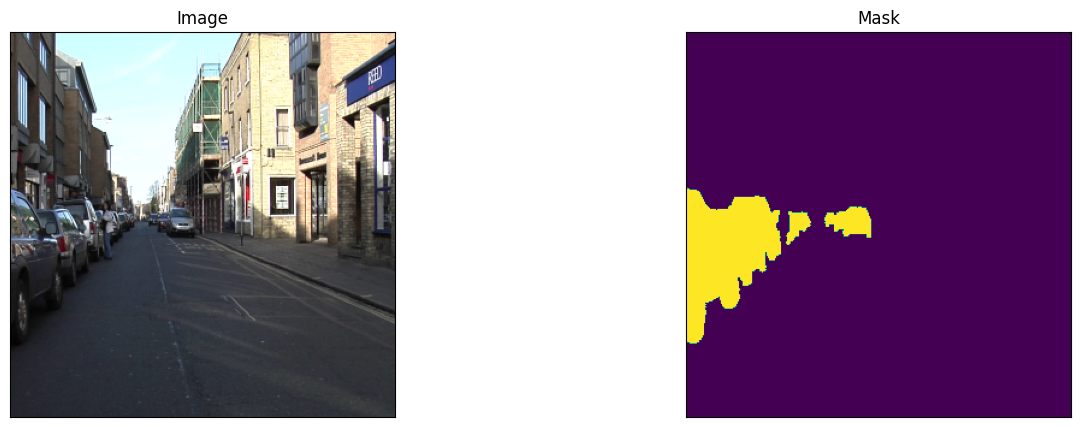

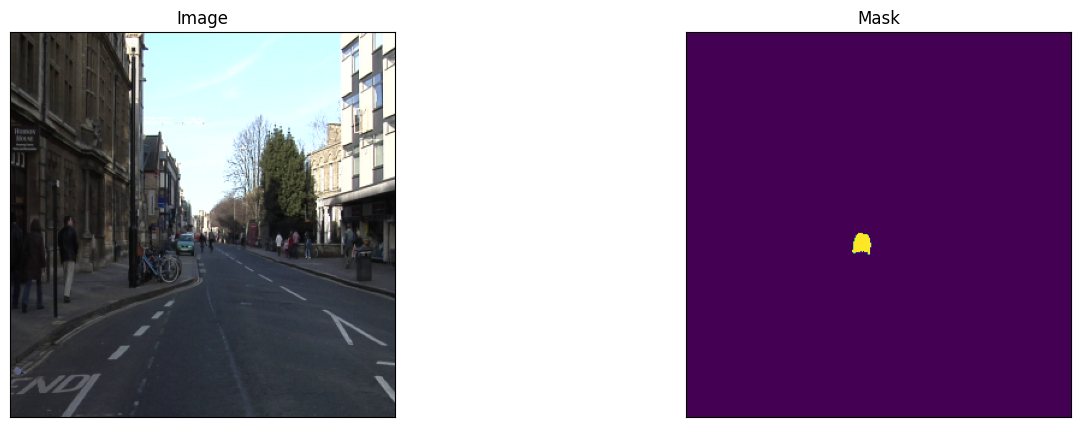

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [ ]:
CLASSES = ['car']

model = smp.Unet('resnet34', encoder_weights='imagenet', activation='sigmoid')

preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet18', pretrained='imagenet')

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device('cpu')
print("Using {}.".format(DEVICE))


Using cuda.


In [ ]:
train_dataset = CutMixDataset(
    x_train_dir,
    y_train_dir,
    0.9,
    20,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Cross Entropy score - https://en.wikipedia.org/wiki/Cross-entropy
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss =  nn.BCEWithLogitsLoss(reduction='none')

loss.__name__ = 'cross_entropy_loss'
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

In [ ]:
# Code modified from smp.utils.train (https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/train.py)

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for data in iterator:
                if len(data) == 2:
                  x, y = data
                  x, y = x.to(self.device), y.to(self.device)
                  loss, y_pred, train = self.batch_update(x, y)
                else:
                  x, y, z = data
                  x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
                  loss, y_pred, train = self.batch_update(x, y)
                  # if we want to update the loss with auxiliary loss
                  # loss = loss + loss * z

                loss = loss.mean()
                if train:
                  loss.backward()
                  self.optimizer.step()
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)

        return loss, prediction, True

class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction, False

train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)

In [ ]:
max_score = 0
train_losses = []
test_losses = []
train_ious = []
test_ious = []
num_epochs = 20

torch.cuda.empty_cache()

for i in range(0, 20):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_wa.pth')
        print('Model saved!')

    train_losses.append(train_logs['cross_entropy_loss'])
    test_losses.append(valid_logs['cross_entropy_loss'])
    train_ious.append(train_logs['iou_score'])
    test_ious.append(valid_logs['iou_score'])
print(max_score)

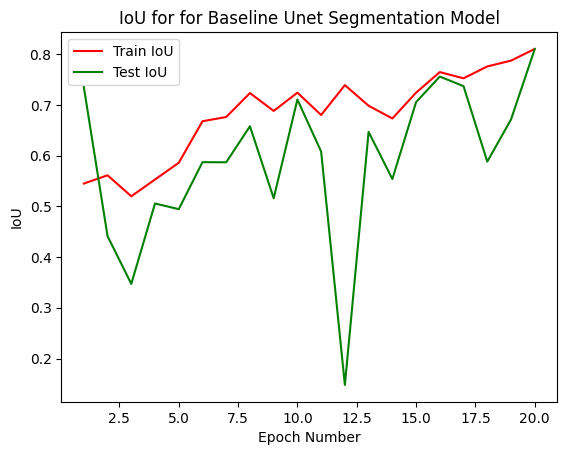

In [ ]:
epochs = [int(i + 1) for i in range(20)]
plt.clf()
plt.plot(epochs, train_losses[:20], label='Train Loss', color = 'r')
plt.plot(epochs, test_losses[:20], label='Test Loss', color = 'g')

plt.title('Losses for Unet Segmentation Model')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.legend()

plt.savefig('Baseline_Loss_wa.jpg')
plt.clf()

plt.plot(epochs, train_ious[:20], label='Train IoU', color = 'r')
plt.plot(epochs, test_ious[:20], label='Test IoU', color = 'g')

plt.title('IoU for for Unet Segmentation Model')
plt.xlabel('Epoch Number')
plt.ylabel('IoU')

plt.legend()

plt.savefig('Baseline_IoU_wa.jpg')

## Test model's stability on images with added Gaussian Noise

In [ ]:
# load best saved checkpoint
best_model = torch.load('/content/best_model_wa (2).pth')

In [ ]:
# create valid dataset
test_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=12)

In [ ]:
import sys
import torch
from tqdm import tqdm as tqdm
import torchnet
from torchnet.meter import AverageValueMeter

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
      str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
      s = ", ".join(str_logs)
      return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs

class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss.mean(), prediction

In [ ]:
def get_test_augmentation(x):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
        albu.GaussNoise(var_limit=x, mean=0, per_channel=True, always_apply=True),
    ]
    return albu.Compose(test_transform)

In [ ]:
test_epoch = ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)

noise_added = []
ious = []
losses = []

for i in range(0, 101, 10):
  test_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_test_augmentation(i),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
  )

  test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=12)
  logs = test_epoch.run(test_dataloader)
  noise_added.append(i)
  ious.append(logs['iou_score'])
  losses.append(logs['cross_entropy_loss'])

print(noise_added)
print(ious)
print(losses)

valid: 100%|██████████| 13/13 [01:19<00:00,  6.12s/it, cross_entropy_loss - 0.6882, iou_score - 0.8197]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.8216385016074547, 0.8198839196792015, 0.8218562511297373, 0.8218652330912076, 0.8195935166799104, 0.8190725629146283, 0.8230671653380761, 0.81821536559325, 0.8188482293715844, 0.8219592112761277, 0.8196772199410659]
[0.6882509222397438, 0.6882675565206087, 0.6882401658938482, 0.6882422107916611, 0.6882613851473881, 0.6882427151386554, 0.6882197856903076, 0.6882513532271752, 0.6882573136916527, 0.6882294003780073, 0.6882462639075059]


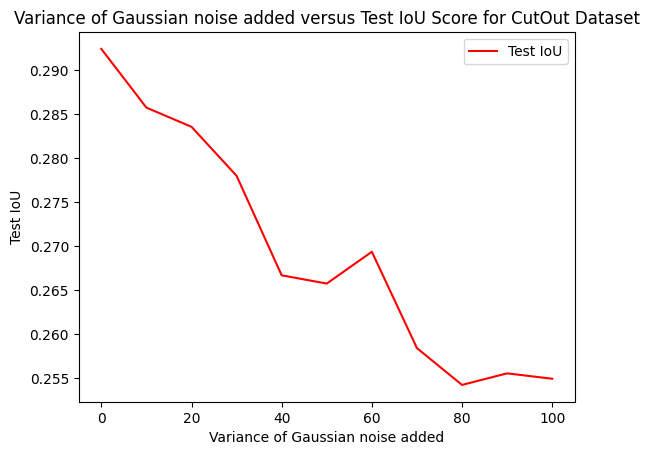

In [ ]:
plt.clf()
plt.plot(noise_added, ious, label='Test IoU', color = 'r')

plt.title('Variance of Gaussian noise added versus Test IoU Score for CutOut Dataset')
plt.xlabel('Variance of Gaussian noise added')
plt.ylabel('Test IoU')

plt.legend()

plt.savefig('noise_cutout.jpg')